In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import elvet
import matplotlib.pyplot as plt
import pandas as pd

Metal device set to: Apple M1
 Elvet: If you use Elvet in research, please cite arXix:2103.14575


In [2]:
tf.__version__

'2.10.0'

In [3]:
#=========================================================
#   Re-assembly of the NN models for Jb, Jf 
#=========================================================

# using the same domain but different models for Jb and Jb

domain0 = elvet.box((-50, 100, 3001)) 

model01 = elvet.nn(1, 25, 25, 25, 1)
model02 = elvet.nn(1, 20, 20, 20, 1)

# loading Jb specific information

Jb_profile = pd.read_csv('Jb.csv', header=None, names=['Jb(x)'], index_col=0)
Jb = np.array([Jb_profile['Jb(x)'][i] for i in range(3001)]).reshape(3001,1)

fitter_Jb = elvet.fitter(domain0, Jb, model=model01, lr=0.001)
fitter_Jb.load_model_weights("Jb.h5")

fitter_Jb.fit(epochs=100)

# loading Jf specific information

Jf_profile = pd.read_csv('Jf.csv', header=None, names=['Jf(x)'], index_col=0)
Jf = np.array([Jf_profile['Jf(x)'][i] for i in range(3001)]).reshape(3001,1)

fitter_Jf = elvet.fitter(domain0, Jf, model=model02, lr=0.001)
fitter_Jf.load_model_weights("Jf.h5")

fitter_Jf.fit(epochs=100)

# graphical verification of accurate fitting 

plt.plot(domain0, fitter_Jb.model(domain0))
plt.plot(domain0, fitter_Jf.model(domain0))
plt.grid(True)
plt.savefig("Figures/fitted_Jb_Jf_verification.jpg")
plt.close()

 Elvet: Setting optimizer parameter 'lr' to 0.001
 Elvet: Setting optimizer parameter 'lr' to 0.001


### Function definitions

#### Thermal functions

In [4]:
def JB(var):
    return fitter_Jb.model(var)

def JF(var):
    return fitter_Jf.model(var)

def dJB(var):
    var_b = tf.cast(var, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(var_b) 
        y_Jb = fitter_Jb.model(var_b)
    return tape.gradient(y_Jb, var_b)

def dJF(var):
    var_f = tf.cast(var, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(var_f) 
        y_Jf = fitter_Jf.model(var_f)
    return tape.gradient(y_Jf, var_f)

#### h, T - dependent masses and their derivatives

In [5]:

def mWsq_t(h):
    g2 = 0.6485
    return 0.25 * g2**2 * h**2

def mWsq_t_prime(h):
    g2 = 0.6485
    return 0.5 * g2**2 * h


def mWsq_l(h,T):
    g2 = 0.6485
    return 0.25 * g2**2 * h**2 + (11/6) * g2**2 * T**2

def mWsq_l_prime(h,T):
    g2 = 0.6485
    return 0.5 * g2**2 * h


def mZsq_t(h):
    (g1, g2) = (0.4632, 0.6485)
    return 0.25 * (0.6 * g1**2 + g2**2) * h**2

def mZsq_t_prime(h):
    (g1, g2) = (0.4632, 0.6485)
    return 0.5 * (0.6 * g1**2 + g2**2) * h


def delta(h,T):
    (g1, g2) = (0.4632, 0.6485)
    return (1/60) * tf.math.sqrt(-2640 * T**2 * g1**2 * g2**2 * (11 * T**2 + 3 * h**2) + (22 * T**2 + 3 * h**2)**2 * (5 * g2**2 + 3 * g1**2)**2)

def delta_prime(h,T):              
    (g1, g2) = (0.4632, 0.6485)
    return (1/60) * (-7920 * h * T**2 * g1**2 * g2**2 + 6 * h * (5 * g2**2 + 3 * g1**2)**2 * (22 * T**2 + 3 * h**2)) / (tf.math.sqrt(-2640 * T**2 * g1**2 * g2**2 * (11 * T**2 + 3 * h**2) + (22 * T**2 + 3 * h**2)**2 * (5 * g2**2 + 3 * g1**2)**2))


def mZsq_l(h,T):
    (g1, g2) = (0.4632, 0.6485)
    return 0.5 * (0.25 * (0.6 * g1**2 + g2**2) * h**2 + (11/6) * g2**2 * T**2 + (11/10) * g1**2 * T**2 + delta(h,T))

def mZsq_l_prime(h,T):
    (g1, g2) = (0.4632, 0.6485)
    return 0.5 * (0.5 * (0.6 * g1**2 + g2**2) * h + delta_prime(h,T))


def mphsq_l(h,T):
    (g1, g2) = (0.4632, 0.6485)
    return 0.5 * (0.25 * (0.6 * g1**2 + g2**2) * h**2 + (11/6) * g2**2 * T**2 + (11/10) * g1**2 * T**2 - delta(h,T))

def mphsq_l_prime(h,T):
    (g1, g2) = (0.4632, 0.6485)
    return 0.5 * (0.5 * (0.6 * g1**2 + g2**2) * h - delta_prime(h,T))


def mGsq(h,T):
    (mHsq, lmbd, g1, g2, yt, lmbd_SH, N) = (0.286270859792, -0.6888422590446, 0.4632, 0.6485, 0.92849, 10.90, 0.5)
    return mHsq + 0.5 * lmbd * h**2 + ((3/80) * g1**2 + (3/16) * g2**2 + (1/4) * yt**2 + (N*lmbd_SH / 12)) * T**2

def mGsq_prime(h,T):
    (mHsq, lmbd, g1, g2, yt, lmbd_SH, N) = (0.286270859792, -0.6888422590446, 0.4632, 0.6485, 0.92849, 10.90, 0.5)
    return lmbd * h


def mhsq(h,T):
    (mHsq, lmbd, g1, g2, yt, lmbd_SH, N) = (0.286270859792, -0.6888422590446, 0.4632, 0.6485, 0.92849, 10.90, 0.5)
    return mHsq + 1.5 * lmbd * h**2 + ((3/80) * g1**2 + (3/16) * g2**2 + (1/4) * yt**2 + (N*lmbd_SH / 12)) * T**2

def mhsq_prime(h,T):
    (mHsq, lmbd, g1, g2, yt, lmbd_SH, N) = (0.286270859792, -0.6888422590446, 0.4632, 0.6485, 0.92849, 10.90, 0.5)
    return 3 * lmbd * h


def mtsq(h):
    yt = 0.92849                 
    return 0.5 * yt**2 * h**2 

def mtsq_prime(h):
    yt = 0.92849                 
    return yt**2 * h

def mbsq(h):
    yb = 0.0167
    return 0.5 * yb**2 * h**2 

def mbsq_prime(h):
    yb = 0.0167
    return yb**2 * h 


def mSsq(h,T):
    (muSsq, lmbd_SH, lmbd_S, N) = (4.4819542, 10.90, 1.0, 0.5)    
    return muSsq + 0.5 * lmbd_SH * h**2 + ((lmbd_S / 12) * (N+1) + (lmbd_SH / 6)) * T**2

def mSsq_prime(h,T):
    (muSsq, lmbd_SH, lmbd_S, N) = (4.4819542, 10.90, 1.0, 0.5)    
    return lmbd_SH * h



#### The Higgs potential and its derivatives

In [6]:
def Vh_oneloop(h,Temp):     
    hc = tf.cast(h, tf.complex64)
    T = Temp/80

    (mHsq, lmbd, N, mu) = (0.286270859792, -0.6888422590446, 0.5, 2.1595)

    Vh_oneloop_corrected = tf.math.real(0.5 * mHsq**2/lmbd +  0.5 * mHsq * hc**2 + 0.125 * lmbd * hc**4 + ( tf.math.xlogy(4*mWsq_t(hc)**2, mWsq_t(hc)/mu**2) - (10/3) * mWsq_t(hc)**2 + tf.math.xlogy(2*mWsq_l(hc,T)**2, mWsq_l(hc,T)/mu**2) - (5/3) * mWsq_l(hc,T)**2 +  tf.math.xlogy(2*mZsq_t(hc)**2, mZsq_t(hc)/mu**2) - (5/3) * mZsq_t(hc)**2 + tf.math.xlogy(mZsq_l(hc,T)**2, mZsq_l(hc,T)/mu**2) - (5/6) * mZsq_l(hc,T)**2 + tf.math.xlogy(mphsq_l(hc,T)**2, mphsq_l(hc,T)/mu**2) - (5/6) * mphsq_l(hc,T)**2 + tf.math.xlogy(3 * mGsq(hc,T)**2, mGsq(hc,T)/mu**2) - 4.5 * mGsq(hc,T)**2 + tf.math.xlogy(mhsq(hc,T)**2, mhsq(hc,T)/mu**2) - 1.5 * mhsq(hc,T)**2 + tf.math.xlogy(2*N * mSsq(hc,T)**2, mSsq(hc,T)/mu**2) - 3*N * mSsq(hc,T)**2 - tf.math.xlogy(12 * mtsq(hc)**2, mtsq(hc)/mu**2) + 18 * mtsq(hc)**2 - tf.math.xlogy(12 * mbsq(hc)**2, mbsq(hc)/mu**2) + 18 * mbsq(hc)**2 ) / (64 * np.math.pi**2))

    return Vh_oneloop_corrected

def Vh_zeroT_atvev():
    
    (mHsq, lmbd, N, mu, vevh) = (0.286270859792, -0.6888422590446, 0.5, 2.1595, 3.08204)
    vevhc = tf.cast(vevh, tf.complex64)

    Vh_zeroT_atvevh = tf.math.real(0.5 * mHsq**2/lmbd + 0.5 * mHsq * vevhc**2 + 0.125 * lmbd * vevhc**4 + ( tf.math.xlogy(6 * mWsq_t(vevhc)**2, mWsq_t(vevhc)/mu**2) - 5 * mWsq_t(vevhc)**2 + tf.math.xlogy(3 * mZsq_t(vevhc)**2, mZsq_t(vevhc)/mu**2) - 2.5 * mZsq_t(vevhc)**2 + tf.math.xlogy(3 * mGsq(vevhc,0)**2, mGsq(vevhc,0)/mu**2) - 4.5 * mGsq(vevhc,0)**2 + tf.math.xlogy(mhsq(vevhc,0)**2, mhsq(vevhc,0)/mu**2) - 1.5 * mhsq(vevhc,0)**2 + tf.math.xlogy(2*N * mSsq(vevhc,0)**2, mSsq(vevhc,0)/mu**2) - 3*N * mSsq(vevhc,0)**2 - tf.math.xlogy(12 * mtsq(vevhc)**2, mtsq(vevhc)/mu**2) + 18 * mtsq(vevhc)**2 - tf.math.xlogy(12 * mbsq(vevhc)**2, mbsq(vevhc)/mu**2) + 18 * mbsq(vevhc)**2 ) / (64 * np.math.pi**2) )

    return Vh_zeroT_atvevh

def Vh_finiteT(h, Temp):
    hf = tf.cast(h, tf.float32)
    T = Temp/80
    N = 0.5

    Vh_finiteT = (T**4) * ( 4*JB(mWsq_t(hf)/T**2) + 2*JB(mWsq_l(hf,T)/T**2) + 2*JB(mZsq_t(hf)/T**2) + JB(mZsq_l(hf,T)/T**2) + JB(mphsq_l(hf,T)/T**2) + 3*JB(mGsq(hf,T)/T**2) + JB(mhsq(hf,T)/T**2) + 2*N*JB(mSsq(hf,T)/T**2) - 12*JF(mtsq(hf)/T**2) - 12*JF(mbsq(hf)/T**2) - 156.33975 ) / (2*np.math.pi**2)

    return Vh_finiteT

def V_h(h, Temp):
    VhT_potential = Vh_finiteT(h, Temp) + Vh_oneloop(h, Temp) - Vh_zeroT_atvev()

    return VhT_potential

def dVh_dh_oneloop(h, Temp):
    hc = tf.cast(h, tf.complex64)
    T = Temp/80

    (mHsq, lmbd, N, mu) = (0.286270859792, -0.6888422590446, 0.5, 2.1595)

    dVh_oneloop = tf.math.real( mHsq * hc + 0.5 * lmbd * hc**3 + ( tf.math.xlogy(8*mWsq_t(hc)*mWsq_t_prime(hc), mWsq_t(hc)/mu**2) - (8/3)*mWsq_t(hc)*mWsq_t_prime(hc) + tf.math.xlogy(4*mWsq_l(hc,T)*mWsq_l_prime(hc,T), mWsq_l(hc,T)/mu**2) - (4/3)*mWsq_l(hc,T)*mWsq_l_prime(hc,T) +  tf.math.xlogy(4*mZsq_t(hc)*mZsq_t_prime(hc), mZsq_t(hc)/mu**2) - (4/3)*mZsq_t(hc)*mZsq_t_prime(hc) + tf.math.xlogy(2*mZsq_l(hc,T)*mZsq_l_prime(hc,T), mZsq_l(hc,T)/mu**2) - (2/3)*mZsq_l(hc,T)*mZsq_l_prime(hc,T) + tf.math.xlogy(2*mphsq_l(hc,T)*mphsq_l_prime(hc,T), mphsq_l(hc,T)/mu**2) - (2/3)*mphsq_l(hc,T)*mphsq_l_prime(hc,T) + tf.math.xlogy(6*mGsq(hc,T)*mGsq_prime(hc,T), mGsq(hc,T)/mu**2) - 6*mGsq(hc,T)*mGsq_prime(hc,T) + tf.math.xlogy(2*mhsq(hc,T)*mhsq_prime(hc,T), mhsq(hc,T)/mu**2) - 2*mhsq(hc,T)*mhsq_prime(hc,T) + tf.math.xlogy(4*N*mSsq(hc,T)*mSsq_prime(hc,T), mSsq(hc,T)/mu**2) - 4*N*mSsq(hc,T)*mSsq_prime(hc,T) - tf.math.xlogy(24*mtsq(hc)*mtsq_prime(hc), mtsq(hc)/mu**2) + 24*mtsq(hc)*mtsq_prime(hc) - tf.math.xlogy(24*mbsq(hc)*mbsq_prime(hc), mbsq(hc)/mu**2) + 24*mbsq(hc)*mbsq_prime(hc) ) / (64 * np.math.pi**2) )
    
    return dVh_oneloop


def dVh_dh_finiteT(h, Temp):
    ha = tf.cast(h, tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(ha) 
        VhT = Vh_finiteT(ha, Temp)
    return tape.gradient(VhT, ha)

def dVh_dh(h, Temp):          
    return dVh_dh_finiteT(h,Temp) + dVh_dh_oneloop(h, Temp)


def d2Vh_dh2(h, Temp):         
    ha = tf.cast(h, tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(ha) 
        dVhT = dVh_dh(ha, Temp)
    return tape.gradient(dVhT, ha)

In [5]:
hy = elvet.box((0.0, 3.2, 3200)) 
h0 = tf.zeros((len(hy), 1), dtype=tf.float32)

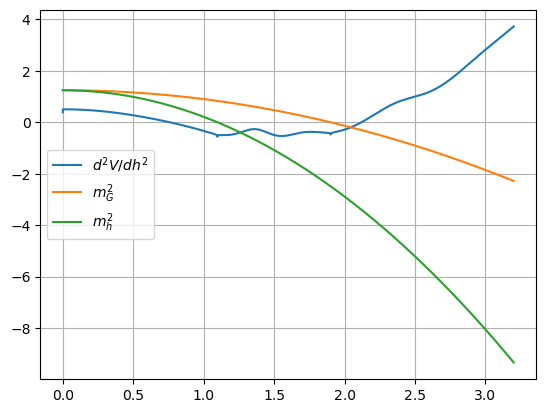

In [8]:
plt.plot(hy, d2Vh_dh2(hy, 90), label="$d^2 V / dh^2$")
plt.plot(hy, mGsq(hy, 90/80), label="$m_G^2$")
plt.plot(hy, mhsq(hy, 90/80), label="$m_h^2$")
plt.legend(loc=6)
plt.grid(True)

### Solving the differential equation using Elvet

In [8]:

full_domain1 = elvet.box((0.01, 10, 1000))

# boundary condition for only the first run, with a guessed value of h(0)

bcs1 = (
    elvet.BC(0.01, lambda r, h, dh, d2h: h - 2.7),
    elvet.BC(0.01, lambda r, h, dh, d2h: dh),
    elvet.BC(10, lambda r, h, dh, d2h: h),
    elvet.BC(10, lambda r, h, dh, d2h: dh)
)

# boundary condition for subsequent runs, with a guessed value of h(0)

bcs2 = (
    elvet.BC(0.01, lambda r, h, dh, d2h: dh),
    elvet.BC(10, lambda r, h, dh, d2h: h),
    elvet.BC(10, lambda r, h, dh, d2h: dh)
)


def eqnT55(r, h, dh, d2h):
    
    return d2h + (2/r)*dh  - dVh_dh(h,55)



 Elvet: epoch = 1, loss = 4.01e+00, lr = 1.00e-03, elapsed time = 00:00:18
 Elvet - WARNING: Training stopped by the user.
 Elvet: epoch = 1675, loss = 3.20e-03, lr = 9.00e-04, elapsed time = 00:04:06


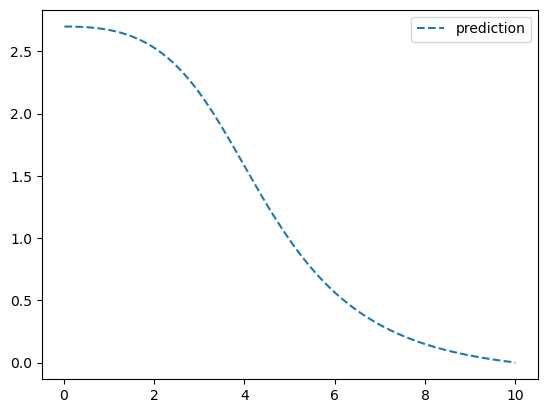

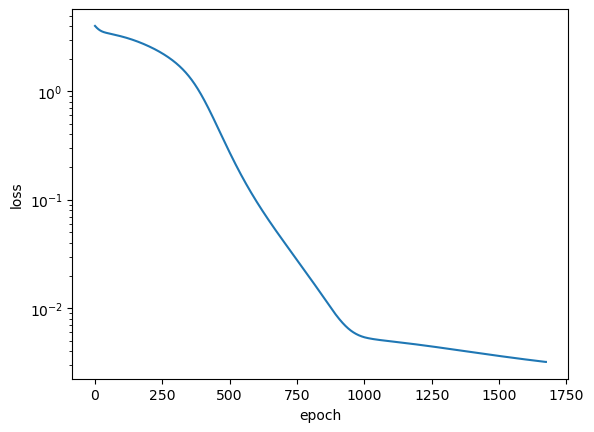

In [9]:
result_1 = elvet.solver(eqnT55, bcs1, domain=full_domain1, model=elvet.nn(1, 10, 10, 10, 1), epochs=10000, verbose=True, metrics=elvet.utils.metrics.WatchLR(True), callbacks=(elvet.utils.LRschedulers.ReduceLROnPlateau(check_every=1000, min_lr=1e-8, scale=0.9, min_improvement_rate=0.01, store_lr=True), elvet.utils.callbacks.EarlyStopping(min_loss=1e-6), elvet.utils.callbacks.TerminateIf(NaN=True, Inf=True, strictly_increasing=False) ))

import elvet.plotting

elvet.plotting.plot_prediction(result_1)
elvet.plotting.plot_losses(result_1)

### If the nan problem persists - consider converting the entire potential or the derivative into an NN fitted model

### The same can be done for the case with the dilaton as well, in the fitter we can give 

$\texttt{domain=elvet.box((0,4,400),(0,4,400))}$

### Of course this will have to be done for individual temperatures or for generalization we can define a T-dependent function and do it for a few different temperatures and save their weights.

In [52]:

#========================
#  Computing the action
#========================

def compute_action(r, h, dh, T):
    kinetic = 0.5 * dh**2
    potential = V_h(h, T) -  V_h(tf.zeros((len(h), 1), dtype=tf.float32), T)

    factor = 4*np.math.pi*(np.array(r)**2) 

    integrand  = np.multiply(factor, (kinetic + potential))

    return np.trapz(integrand, r)/(T/80)


In [30]:
r = np.linspace(0.01,100,10000)
ha = 3.0/(1+np.exp(r-7))
dha = np.gradient(ha)/np.gradient(r)

In [50]:
r2 = elvet.box((0.01,100,10000))
ha = tf.cast(3.0/(1+tf.math.exp(r-7)), tf.float32)
hb = tf.reshape(ha, r2.shape)
hb

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[2.9972394],
       [2.9972117],
       [2.9971838],
       ...,
       [0.       ],
       [0.       ],
       [0.       ]], dtype=float32)>

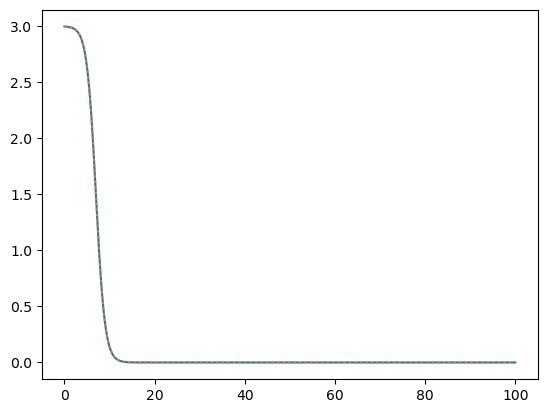

In [51]:
plt.plot(r,ha)
plt.plot(r2,hb, linestyle="dotted")

In [48]:
hb

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[2.9972394],
       [2.9972117],
       [2.9971838],
       ...,
       [0.       ],
       [0.       ],
       [0.       ]], dtype=float32)>